In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import mplfinance as mpf
import yfinance as yf

# データの取得

## 1日単位の取得
pandas_datareaderを使える

In [2]:
# end = datetime.now() - pd.Timedelta(days=1)
end = pd.Timestamp("2022-06-22")

In [3]:
source = "yahoo"
days = 365
start = end - pd.Timedelta(days=days)
(start, end)

(Timestamp('2021-06-22 00:00:00'), Timestamp('2022-06-22 00:00:00'))

In [4]:
pair = "USDJPY"
df=DataReader(f"{pair}=X", source, start=start, end=end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-06-21,110.788002,110.221001,110.385002,110.374001,0,110.374001
2021-06-22,111.091003,110.684998,110.684998,110.653999,0,110.653999
2021-06-23,111.095001,110.709999,110.986000,111.012001,0,111.012001
2021-06-24,110.974998,110.482002,110.917000,110.920998,0,110.920998
2021-06-27,110.971001,110.507004,110.804001,110.821999,0,110.821999
...,...,...,...,...,...,...
2022-06-16,135.412003,132.186996,132.421005,132.421005,0,132.421005
2022-06-19,135.412003,134.548996,135.276001,135.276001,0,135.276001
2022-06-20,136.328995,134.945007,135.087006,135.087006,0,135.087006


In [5]:
# なぜか同日のOpenとCloseの値がほぼ同じなため, 修正する
df["Open"]=df["Close"].shift(1)
df["High"]=np.maximum(df["High"], df["Close"])
df["Low"]=np.minimum(df["Low"], df["Close"])
df=df.iloc[1:]

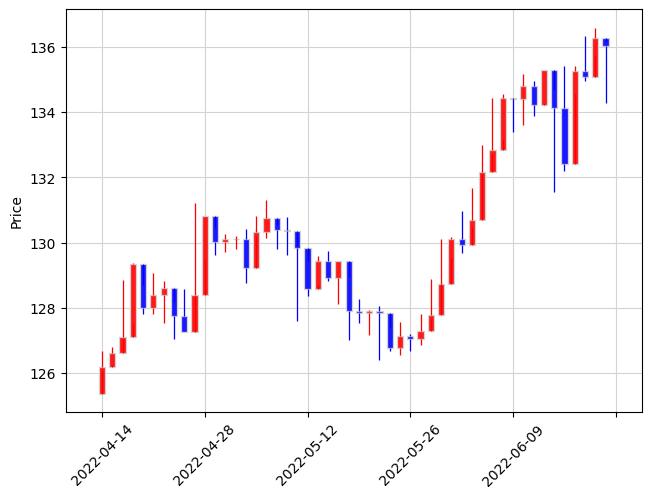

In [6]:
mc = mpf.make_marketcolors(
    up="red", down="blue", volume="black", edge="lightgray", 
    wick={"up":"red", "down":"blue"}
)
cs = mpf.make_mpf_style(marketcolors=mc, gridcolor="lightgray")

length=50
mpf.plot(df.tail(length), type="candle", datetime_format="%Y-%m-%d", style=cs)

In [7]:
mpf.plot(df.tail(length), type="candle", datetime_format="%Y-%m-%d", style=cs, savefig="img/chart.svg")

## 1日より細かい単位の取得
1日より細かい単位で取得するにはyfinanceを使う

In [8]:
pair="USDJPY"
df_hour=yf.download(tickers=f"{pair}=X", period="2d", interval="1h", end=end)

[*********************100%***********************]  1 of 1 completed


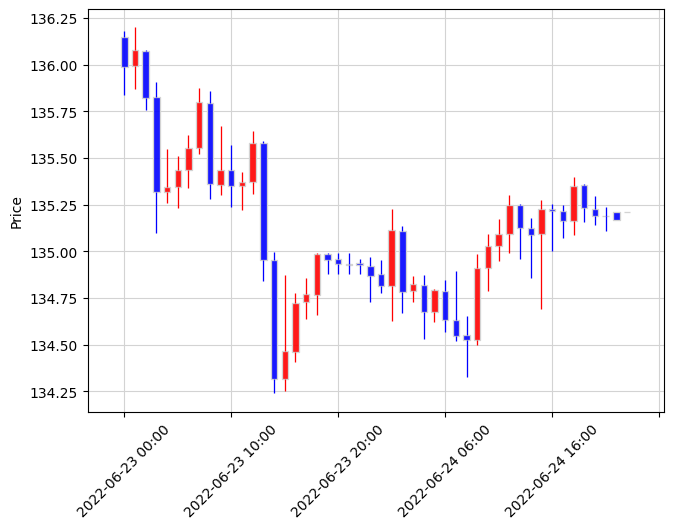

In [9]:
mpf.plot(df_hour, type="candle", datetime_format="%Y-%m-%d %H:%M", style=cs)

# 相関

## 通貨ペアの相関

In [10]:
days = 365*4
start = end - pd.Timedelta(days=days)
(start, end)

(Timestamp('2018-06-23 00:00:00'), Timestamp('2022-06-22 00:00:00'))

In [11]:
pairs=[
    "CADJPY",
    "EURJPY",
    "AUDNZD",
    "USDCAD",
    "EURGBP",
    "USDJPY",
    "EURUSD",
    "AUDJPY",
    "AUDUSD",
    "NZDJPY",
    "NZDUSD",
    "GBPJPY",
    "GBPUSD",
    "TRYJPY",
    "ZARJPY",
    "MXNJPY",
]

In [12]:
dfs=[DataReader(f"{pair}=X", source, start=start, end=end) for pair in pairs]

In [13]:
# serieses=[(_df["High"]+_df["Low"])/2 for _df in dfs]
serieses=[_df["Close"] for _df in dfs]

In [14]:
df_all=pd.DataFrame(serieses, index=pairs).T

In [15]:
corr=df_all.corr()

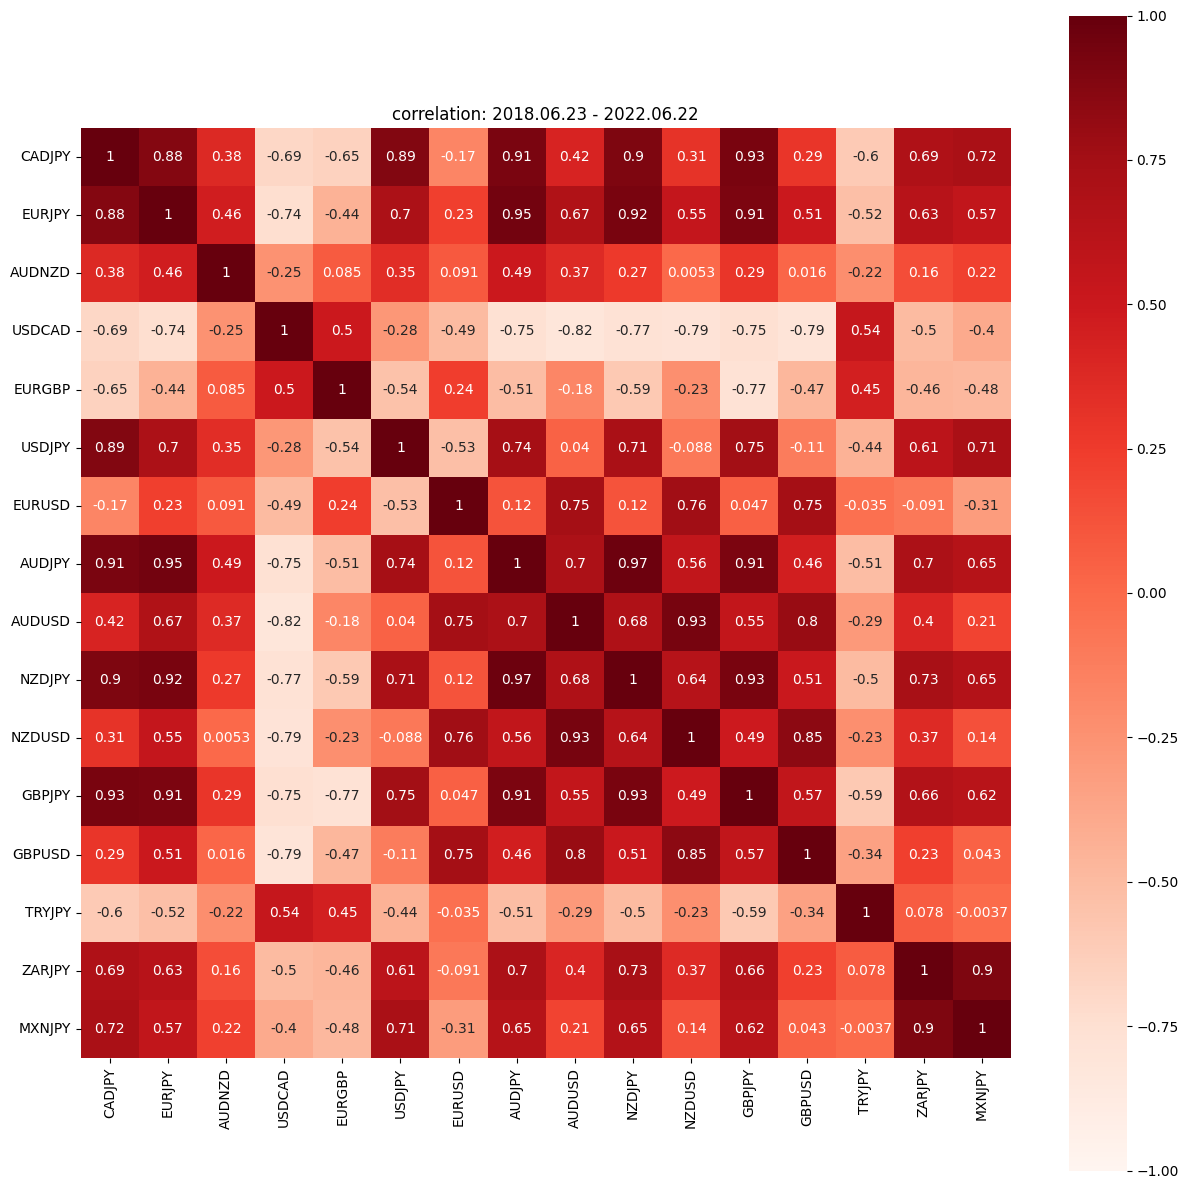

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="Reds", annot=True, vmin = -1, vmax = 1, square=True)
plt.title(f"correlation: {start.strftime('%Y.%m.%d')} - {end.strftime('%Y.%m.%d')}")
plt.savefig("img/corr.svg")

## 2通貨の移動相関

In [17]:
pair1="EURJPY"
pair2="AUDNZD"

In [18]:
df1=DataReader(f"{pair1}=X", source, start=start, end=end)
df2=DataReader(f"{pair2}=X", source, start=start, end=end)

In [19]:
# x1=(df1["High"]+df1["Low"])/2
# x2=(df2["High"]+df2["Low"])/2
x1=df1["Close"]
x2=df2["Close"]

In [20]:
print(set(x1.index)-set(x2.index))
print(set(x2.index)-set(x1.index))

set()
set()


In [21]:
x1.corr(x2)

0.4636883546178631

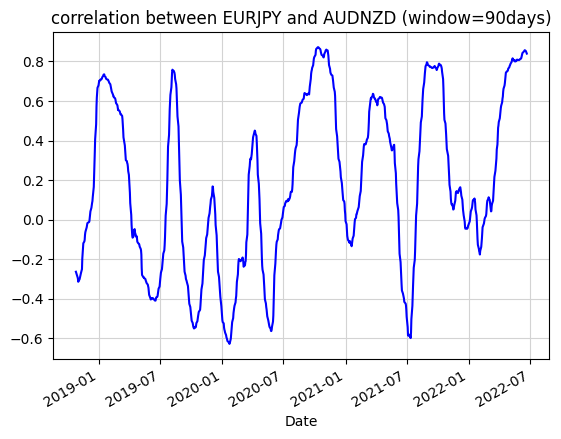

In [22]:
window=90
x1.rolling(window).corr(x2).plot(color="blue")
plt.title(f"correlation between {pair1} and {pair2} (window={window}days)")
plt.savefig(f"img/{pair1}_{pair2}.svg")

# テクニカル分析

In [23]:
source = "yahoo"
days = 365//2
start = end - pd.Timedelta(days=days)
(start, end)

(Timestamp('2021-12-22 00:00:00'), Timestamp('2022-06-22 00:00:00'))

In [24]:
pair = "CADUSD"
# pair = "AUDNZD"
df=DataReader(f"{pair}=X", source, start=start, end=end)

## 移動平均線

In [25]:
window=5
price = df["Close"]

In [26]:
moving_mean = price.rolling(window).mean()

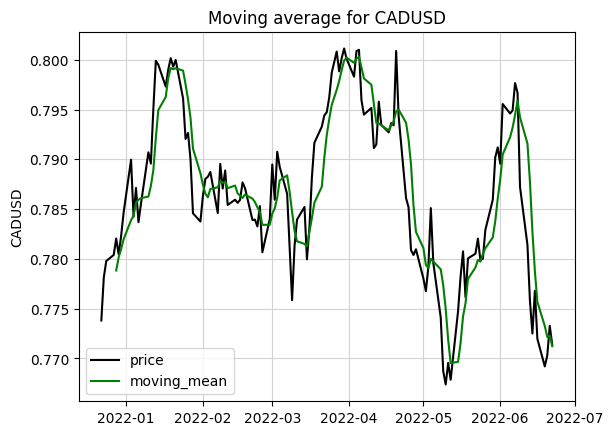

In [27]:
plt.plot(price.index, price, "k", label="price")
plt.plot(moving_mean.index, moving_mean, "g", label="moving_mean")
plt.ylabel(pair)
plt.title(f"Moving average for {pair}")
plt.legend()
plt.savefig("img/MovingAverage.svg")

## ボリンジャーバンド
上のバンドをはみ出たら上昇トレンド, 下のバンドをはみ出たら下降トレンド

- 移動平均 ± 標準偏差 x k
- k
    - k=1: 約68.3%
    - k=2: 約95.4%
    - k=3: 約99.7%

In [28]:
moving_std = price.rolling(window).std()
k=1
upper_band = moving_mean + k*moving_std
lower_band = moving_mean - k*moving_std

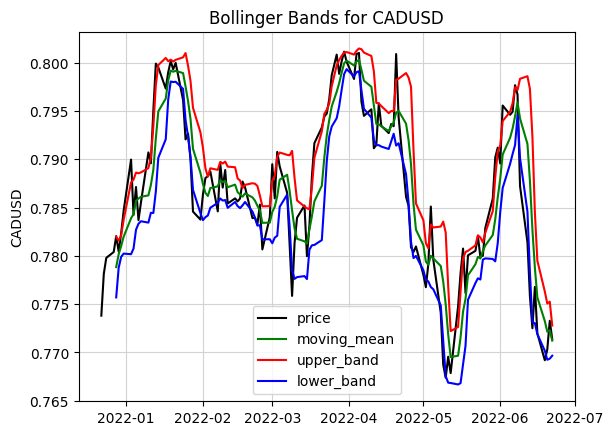

In [29]:
plt.plot(price.index, price, "k", label="price")
plt.plot(moving_mean.index, moving_mean, "g", label="moving_mean")
plt.plot(upper_band.index, upper_band, "r", label="upper_band")
plt.plot(lower_band.index, lower_band, "b", label="lower_band")
plt.ylabel(pair)
plt.title(f"Bollinger Bands for {pair}")
plt.legend()
plt.savefig("img/BollingerBands.svg")

## RSI
相場の相対的な強弱を表す指標
- Relative Strength Index
- 買われすぎ/売られすぎを判断するための指標

In [30]:
diff = price.diff(1)
up_mean = np.maximum(0, diff).rolling(window).mean()
down_mean = np.maximum(0, -diff).rolling(window).mean()
rs = up_mean / down_mean
rsi = 100 - 100/(rs+1)

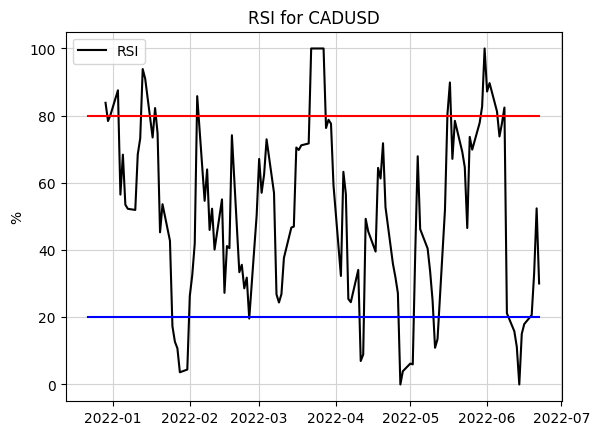

In [31]:
plt.plot(rsi.index, rsi, "k", label="RSI")
plt.plot(rsi.index, [80]*rsi.shape[0], "r")
plt.plot(rsi.index, [20]*rsi.shape[0], "b")
plt.ylabel("%")
plt.title(f"RSI for {pair}")
plt.legend()
plt.savefig("img/RSI.svg")

## MACD
- MACD = 短期EMA - 長期EMA
- MACDシグナル = MACDのEMA

2本のラインの交差点が売買のタイミングとして用いられる

In [32]:
short=12
long=26
signal=9
macd = price.ewm(span=short).mean() - price.ewm(span=long).mean()
macd_signal = macd.ewm(span=signal).mean()

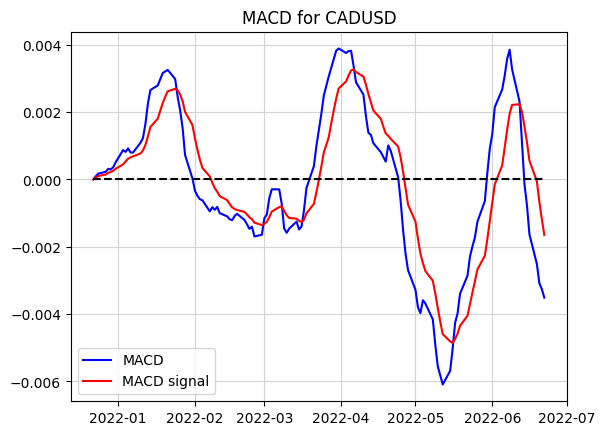

In [33]:
plt.plot(macd.index, macd, "b", label="MACD")
plt.plot(macd_signal.index, macd_signal, "r", label="MACD signal")
plt.plot(macd.index, [0]*macd.shape[0], "k--")
plt.title(f"MACD for {pair}")
plt.legend()
plt.savefig("img/MACD.svg")

## ストキャスティクス
- K = (終値 - n日間のmin)/(n日間のmax-n日間のmin) x 100
- D = (終値 - n日間のmin)のm日合計 / (n日間のmax-n日間のmin)のm日合計 x 100

- 買いシグナル: K, D共に20%以下で, KがDを下から上に抜いた時
- 売りシグナル: K, D共に80%以上で、KがDを上から下に抜いた時

In [34]:
kwindow = 9
dwindow = 3
min_value=price.rolling(kwindow).min()
max_value=price.rolling(kwindow).max()
k_value = (price-min_value)/(max_value-min_value) * 100
d_value = (price-min_value).rolling(dwindow).sum() / (max_value-min_value).rolling(dwindow).sum() * 100
# slow_d_value = k_value.rolling(dwindow).mean()

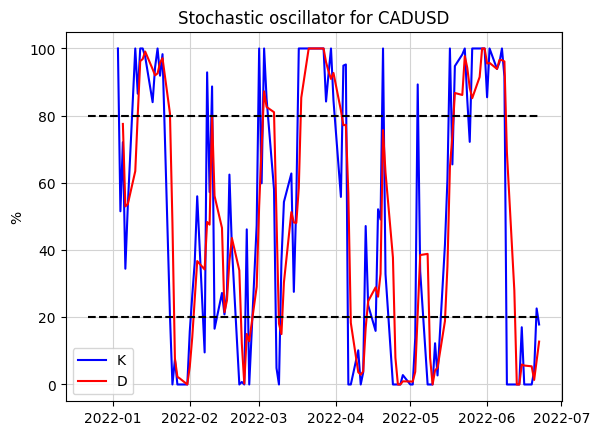

In [35]:
plt.plot(k_value.index, k_value, "b", label="K")
plt.plot(d_value.index, d_value, "r", label="D")
plt.plot(k_value.index, [80]*k_value.shape[0], "k--")
plt.plot(k_value.index, [20]*k_value.shape[0], "k--")
plt.ylabel("%")
plt.title(f"Stochastic oscillator for {pair}")
plt.legend()
plt.savefig("img/StochasticOscillator.svg")